In [1]:
import math
import numpy as np

import drawSvg as draw
from drawSvg import Drawing
from hyperbolic import euclid, util
from hyperbolic.poincare.shapes import *
from hyperbolic.poincare import Transform
from hyperbolic.poincare.util import radialEuclidToPoincare, radialPoincareToEuclid, \
                                     poincareToEuclidFactor, triangleSideForAngles
import hyperbolic.tiles as htiles

In [2]:
def drawTiles(drawing, tiles):
    for tile in tiles:
        d.draw(tile, hwidth=0.02, fill='white')
    for tile in tiles:
        d.draw(tile, drawVerts=True, hradius=0.15, hwidth=0.02,
                     fill='black', opacity=0.6)

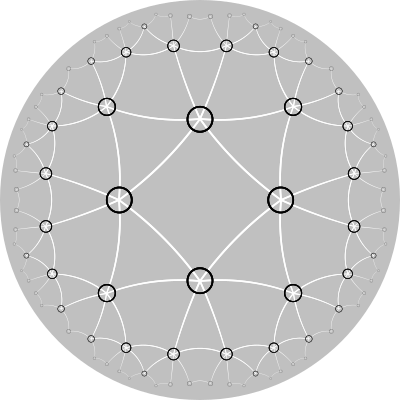

In [3]:
p1 = 4
p2 = 3
q = 3

theta1, theta2 = math.pi*2/p1, math.pi*2/p2
phiSum = math.pi*2/q
r1 = triangleSideForAngles(theta1/2, phiSum/2, theta2/2)
r2 = triangleSideForAngles(theta2/2, phiSum/2, theta1/2)

tGen1 = htiles.TileGen.makeRegular(p1, hr=r1, skip=1)
tGen2 = htiles.TileGen.makeRegular(p2, hr=r2, skip=1)

tLayout = htiles.TileLayout()
tLayout.addGenerator(tGen1, (1,)*p1)
tLayout.addGenerator(tGen2, (0,)*p2)
startTile = tLayout.defaultStartTile(rotateDeg=90)

tiles = tLayout.tilePlane(startTile, depth=4)

d = Drawing(2, 2, origin='center')
d.draw(euclid.shapes.Circle(0, 0, 1), fill='silver')
drawTiles(d, tiles)

d.setRenderSize(w=400)
d.saveSvg('images/tileTriangleSquare.svg')
d

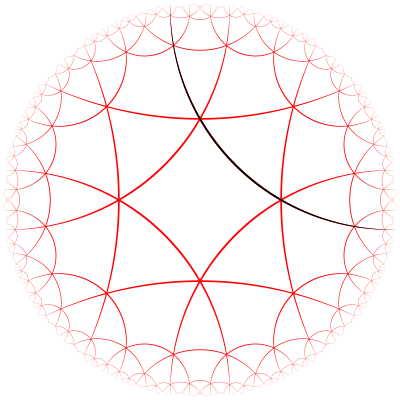

In [4]:
p1 = 4
p2 = 3
q = 3
rotate = 0

theta1, theta2 = math.pi*2/p1, math.pi*2/p2
phiSum = math.pi*2/q
r1 = triangleSideForAngles(theta1/2, phiSum/2, theta2/2)
r2 = triangleSideForAngles(theta2/2, phiSum/2, theta1/2)

tGen1 = htiles.TileGen.makeRegular(p1, hr=r1, skip=1)
tGen2 = htiles.TileGen.makeRegular(p2, hr=r2, skip=1)

tLayout = htiles.TileLayout()
tLayout.addGenerator(tGen1, (1,)*p1)
tLayout.addGenerator(tGen2, (0,)*p2, htiles.TileDecoratorNull())
startTile = tLayout.defaultStartTile(rotateDeg=rotate)

t1 = startTile
t2 = tLayout.placeTile(t1.sides[-1])
t3 = tLayout.placeTile(t2.sides[-1])
pointBase = t3.vertices[-1]
points = [Transform.rotation(deg=i*360/p1).applyToPoint(pointBase)
          for i in range(p1)]
vertices = startTile.vertices
edges = []
for i, point in enumerate(points):
    v1 = vertices[i]
    v2 = vertices[(i+1)%p1]
    edge = Hypercycle.fromPoints(*v1, *v2, *point, segment=True, excludeMid=True)
    edges.append(edge)
decoratePoly = Polygon(edges=edges, vertices=vertices)
decorator1 = htiles.TileDecoratorPolygons(decoratePoly)
tLayout.setDecorator(decorator1, 0)

startTile = tLayout.defaultStartTile(rotateDeg=rotate)
tiles = tLayout.tilePlane(startTile, depth=6)

d = Drawing(2, 2, origin='center')
#d.draw(euclid.shapes.Circle(0, 0, 1), fill='silver')
for tile in tiles:
    d.draw(tile, hwidth=0.02, fill='red')
tiles[0].decorator = None
d.draw(Hypercycle.fromPoints(*tiles[0].vertices[0],
                             *tiles[0].vertices[1],
                             *pointBase),
       hwidth=0.02, fill='black')

d.setRenderSize(w=400)
d.saveSvg('images/escherOverlay.svg')
d

In [5]:
class TileDecoratorFish(htiles.TileDecoratorPolygons):
    def __init__(self, p1=4, p2=3, q=3):
        theta1, theta2 = math.pi*2/p1, math.pi*2/p2
        phiSum = math.pi*2/q
        r1 = triangleSideForAngles(theta1/2, phiSum/2, theta2/2)
        r2 = triangleSideForAngles(theta2/2, phiSum/2, theta1/2)
        tGen1 = htiles.TileGen.makeRegular(p1, hr=r1)
        tGen2 = htiles.TileGen.makeRegular(p2, hr=r2)

        t1 = tGen1.centeredTile()
        t2 = tGen2.placedAgainstTile(t1, side=-1)
        t3 = tGen1.placedAgainstTile(t2, side=-1)
        pointBase = t3.vertices[-1]
        points = [Transform.rotation(deg=i*360/p1).applyToPoint(pointBase)
                  for i in range(p1)]
        vertices = t1.vertices
        
        edges = []
        for i, point in enumerate(points):
            v1 = vertices[i]
            v2 = vertices[(i+1)%p1]
            edge = Hypercycle.fromPoints(*v1, *v2, *point, segment=True, excludeMid=True)
            edges.append(edge)
        edgePoly = Polygon(edges=edges, vertices=vertices)

        origin = Point(0,0)
        corner = Point.fromHPolar(r1, theta=0)
        corner2 = Transform.rotation(rad=theta1).applyToPoint(corner)
        center = Point.fromHPolar(r2, theta=math.pi-phiSum/2)
        center = Transform.translation(corner).applyToPoint(center)
        poly = Polygon.fromVertices((origin, corner, center, corner2))
        desc = poly.makeRestorePoints()
        descs = [Transform.rotation(deg=i*360/p1).applyToList(desc)
                 for i in range(p1)]

        super().__init__(edgePoly, polyDescs=descs)
        self.p1 = p1
        self.p2 = p2
        self.colors = ['#ffbf00', 'green', 'red', 'blue', 'gray', 'brown']
    def toDrawables(self, elements, tile=None, layer=0, **kwargs):
        if tile is None:
            trans = Transform.identity()
            codes = range(self.p1)
        else:
            trans = tile.trans
            codes = [side.code[1] for side in tile.sides]
        polys = [Polygon.fromRestorePoints(trans.applyToList(desc))
                 for desc in self.polyDescs]
        ds = []
        if layer == 0:
            for i, poly in enumerate(polys[1:]):
                color = self.colors[codes[i]]
                d = poly.toDrawables(elements, fill=color, opacity=0.5, **kwargs)
                ds.extend(d)
        if layer == 1:
            dLast = polys[0].toDrawables(elements, hwidth=0.03, fill='white', **kwargs)
            ds.extend(dLast)
        if layer == 2:
            for i, poly in enumerate(polys[1:]):
                d = poly.toDrawables(elements, hwidth=0.01, fill='black', **kwargs)
                ds.extend(d)
        return ds

In [6]:
class TileLayoutFish(htiles.TileLayout):
    def calcGenIndex(self, code):
        ''' Override in subclass to control which type of tile to place '''
        if code == 0 or code == 1:
                return code
        index, color, cw = code
        return index
    def calcTileTouchSide(self, code, genIndex):
        ''' Override in subclass to control tile orientation '''
        return 0
    def calcSideCodes(self, code, genIndex, touchSide, defaultCodes):
        ''' Override in subclass to control tile side codes '''
        p = len(defaultCodes)
        if code == 0 or code == 1:
            c = (code+1) % 2
            if p % 2 == 0:
                return ((c,0,1),(c,1,0))*(p//2)
            else:
                return ((c,0,1),(c,1,2),(c,2,0))*(p//3)
        index, color, otherColor = code
        c = (index+1) % 2
        # 0=yellow, 1=green, 2=red, 3=blue
        if index == 1:
            newColors = {
                (0,1): (0,2,3),
                (1,0): (1,3,2),
                (0,2): (0,3,1),
                (2,0): (2,1,3),
                (0,3): (0,1,2),
                (3,0): (3,2,1),
                (1,2): (1,0,3),
                (2,1): (2,3,0),
                (1,3): (1,2,0),
                (3,1): (3,0,2),
                (2,3): (2,0,1),
                (3,2): (3,1,0),
            }[(color, otherColor)] * 10
        elif index == 0:
            newColors = {
                (0,1): (0,3,0,3),  # 0,1,2
                (1,2): (1,3,1,3),
                (2,0): (2,3,2,3),
                (0,2): (0,1,0,1),  # 0,2,3
                (2,3): (2,1,2,1),
                (3,0): (3,1,3,1),
                (0,3): (0,2,0,2),  # 0,3,1
                (3,1): (3,2,3,2),
                (1,0): (1,2,1,2),
                (1,3): (1,0,1,0),  # 1,3,2
                (3,2): (3,0,3,0),
                (2,1): (2,0,2,0),
            }[(color, otherColor)] * 10
        else:
            assert False
        newColors = newColors[:p]
        codes = [(c,newColor,newColors[(i+1)%len(newColors)])
                for i, newColor in enumerate(newColors)]
        return codes

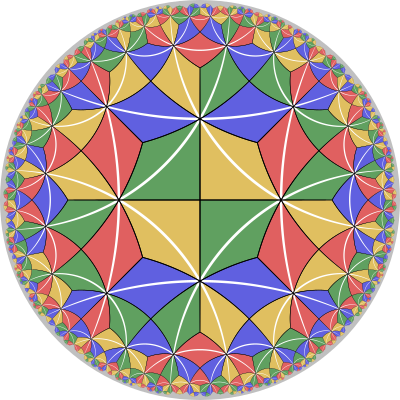

In [7]:
p1 = 4
p2 = 3
q = 3
rotate = 0
depth = 6

theta1, theta2 = math.pi*2/p1, math.pi*2/p2
phiSum = math.pi*2/q
r1 = triangleSideForAngles(theta1/2, phiSum/2, theta2/2)
r2 = triangleSideForAngles(theta2/2, phiSum/2, theta1/2)

tGen1 = htiles.TileGen.makeRegular(p1, hr=r1, skip=1)
tGen2 = htiles.TileGen.makeRegular(p2, hr=r2, skip=1)

decorator1 = TileDecoratorFish(p1, p2, q)

tLayout = TileLayoutFish()
tLayout.addGenerator(tGen1, ((0,1)*10)[:p1], decorator1)
tLayout.addGenerator(tGen2, ((0,1,2)*10)[:p2], htiles.TileDecoratorNull())
startTile = tLayout.startTile(code=0,rotateDeg=rotate)

tiles = tLayout.tilePlane(startTile, depth=depth)

d = Drawing(2, 2, origin='center')
d.draw(euclid.shapes.Circle(0, 0, 1), fill='silver')
for tile in tiles:
    d.draw(tile, layer=0)
for tile in tiles:
    d.draw(tile, layer=1)
for tile in tiles:
    d.draw(tile, layer=2)

d.setRenderSize(w=400)
d.saveSvg('images/escherApprox.svg')
d.rasterize(toFile='images/escherApprox.png')